# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import re
import nltk
from nltk.corpus import stopwords as stopwords_nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Пропусков нет.

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Имеем дисбаланс классов

In [6]:
# переведем текст в нижний регистр.
df['text'] = df['text'].str.lower()

Подготовим текст по следующему алгоритму:
    1. Очищаем его от лишних символов.
    2. Лемматизируем текст.
    3. Удаляем стоп-слова.

In [7]:
# напишем функцию, которая будет очищать текст от лишних символов.
def clear_text(text):
    clear_text = re.sub(r"[^a-zA-Z ]", " ", str(text))
    clear_text = " ".join(clear_text.split())
    return clear_text

In [8]:
# прогоним текст через функцию clear_text
df['clear_text'] = df['text'].apply(lambda x: clear_text(x))

In [9]:
df['clear_text'] 

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i m se...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570    and i really don t think you understand i came...
Name: clear_text, Length: 159571, dtype: object

In [10]:
# напишем функцию, которая будет лемматизировать текст от лишних символов.
def lemmatize_text(text):
    lemmatize_text = nltk.word_tokenize(text)
    return lemmatize_text

In [11]:
# прогоним текст через функцию lemmatize_text
df['lemmatize_text'] = df['clear_text'].apply(lambda x: lemmatize_text(x))
df['lemmatize_text']

0         [explanation, why, the, edits, made, under, my...
1         [d, aww, he, matches, this, background, colour...
2         [hey, man, i, m, really, not, trying, to, edit...
3         [more, i, can, t, make, any, real, suggestions...
4         [you, sir, are, my, hero, any, chance, you, re...
                                ...                        
159566    [and, for, the, second, time, of, asking, when...
159567    [you, should, be, ashamed, of, yourself, that,...
159568    [spitzer, umm, theres, no, actual, article, fo...
159569    [and, it, looks, like, it, was, actually, you,...
159570    [and, i, really, don, t, think, you, understan...
Name: lemmatize_text, Length: 159571, dtype: object

In [12]:
# напишем функцию, которая будет очищать текст от стоп-слов.
STOP_WORDS = set(stopwords_nltk.words('english')) 
def without_stopwords(text):
    without_stopwords = []
    for i in text.split(' '):
        if i not in STOP_WORDS: 
            without_stopwords.append(i)
    return without_stopwords

In [13]:
# прогоним текст через функцию without_stopwords
df['without_stopwords'] = df['clear_text'].apply(lambda x: without_stopwords(x))
df['without_stopwords']

0         [explanation, edits, made, username, hardcore,...
1         [aww, matches, background, colour, seemingly, ...
2         [hey, man, really, trying, edit, war, guy, con...
3         [make, real, suggestions, improvement, wondere...
4                       [sir, hero, chance, remember, page]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567          [ashamed, horrible, thing, put, talk, page]
159568    [spitzer, umm, theres, actual, article, prosti...
159569    [looks, like, actually, put, speedy, first, ve...
159570    [really, think, understand, came, idea, bad, r...
Name: without_stopwords, Length: 159571, dtype: object

In [14]:
# переведем столбец 'without_stopwords' в формат unicode
df['without_stopwords'] = df['without_stopwords'].astype('U')

In [15]:
df.head()

,text,toxic,clear_text,lemmatize_text,without_stopwords
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...","['explanation', 'edits', 'made', 'username', '..."
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,"[d, aww, he, matches, this, background, colour...","['aww', 'matches', 'background', 'colour', 'se..."
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,"[hey, man, i, m, really, not, trying, to, edit...","['hey', 'man', 'really', 'trying', 'edit', 'wa..."
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,"[more, i, can, t, make, any, real, suggestions...","['make', 'real', 'suggestions', 'improvement',..."
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re...","['sir', 'hero', 'chance', 'remember', 'page']"


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 5 columns):
text                 159571 non-null object
toxic                159571 non-null int64
clear_text           159571 non-null object
lemmatize_text       159571 non-null object
without_stopwords    159571 non-null object
dtypes: int64(1), object(4)
memory usage: 6.1+ MB


## Обучение

In [17]:
# выделим признаки и цель для обучения

target = df['toxic']
features = df.drop('toxic', axis = 1)

In [18]:
print(target.shape, features.shape)

(159571,) (159571, 4)


In [19]:
# разделим данные features и target на две части (train и test) в соотношении 75% к 25% 
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [20]:
# посчитаем TF-IDF для корпуса текстов

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

corpus_train = features_train['without_stopwords']
corpus_test = features_test['without_stopwords']

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
tf_idf = count_tf_idf.fit(corpus_train) 

x_train = tf_idf.transform(corpus_train)
x_test = tf_idf.transform(corpus_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
print(x_train.shape, target_train.shape)

(119678, 143178) (119678,)


In [22]:
print(x_test.shape, target_test.shape)

(39893, 143178) (39893,)


Рассмотрем три модели для обучения:
- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression

### DecisionTreeClassifier

In [23]:
best_result = 0
for depth in range(1, 22, 10): 
    model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced', max_depth=depth)
    model.fit(x_train, target_train)
    predictions = model.predict(x_test)
    f1 = f1_score(target_test, predictions)
    if best_result <= f1:
        best_result = f1
        best_depth = depth
        
print('Лучший результат F1 =', best_result, 'при depth = ', best_depth)

Лучший результат F1 = 0.598381244766955 при depth =  21


### RandomForestClassifier

In [24]:
best_result = 0
for depth in range(1,22,10): 
    for estimators in range(1,102,50):
        model = RandomForestClassifier(n_estimators=estimators, class_weight = 'balanced', max_depth=depth, random_state=12345)
        model.fit(x_train, target_train)
        predictions = model.predict(x_test)
        f1 = f1_score(target_test, predictions)
        if best_result <= f1:
            best_result = f1
            best_depth = depth
            best_n_estimators = estimators
            
print('Лучший результат F1 =', best_result, 'при depth = ', best_depth, 'и при n_estimators = ', estimators)

Лучший результат F1 = 0.3932013916614385 при depth =  21 и при n_estimators =  101


### LogisticRegression

In [25]:
model = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', random_state=12345)
model.fit(x_train, target_train)
predictions = model.predict(x_test)
f1 = f1_score(target_test, predictions) 
print('Результат F1 =', f1)

Результат F1 = 0.7588081774684645


## Выводы


Лучше других показала себя модель `LogisticRegression`. 

In [26]:
probabilities_valid = model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print('Значение AUC-ROC =', auc_roc)
print('Значение F1 =', f1)

Значение AUC-ROC = 0.9719745961028794
Значение F1 = 0.7588081774684645


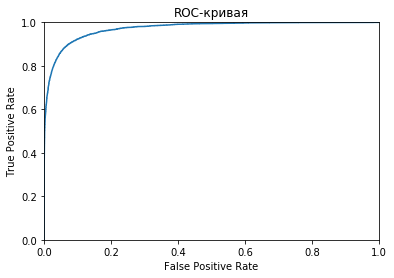

In [27]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

<b>Вывод:

- В качестве итоговой модели выбираем `LogisticRegression`, для которой получили значение метрики `F1 = 0.7588081774684645`.
- ROC - кривая находится выше диагонали. Значение `AUC-ROC` для итоговой модели `0.9719745961028794`.